# Загрузка изображений и создание панорамы
# подумать о том, важен ли порядок - первое изображение то, что слева или наоборот?
image1_path = "street_1.jpeg"  # Путь к первому изображению
image2_path = "street_2.jpeg"  # Путь ко второму изображению

img1 = cv2.imread(image1_path)
img2 = cv2.imread(image2_path)

if img1 is None or img2 is None:
    raise FileNotFoundError("Одно из изображений не найдено.")

# Шаг 1: Преобразование в градации серого
# (Для упрощения обработки изображений и поиска ключевых точек преобразуем изображения в оттенки серого с помощью)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Шаг 2: Инициализация SIFT и обнаружение ключевых точек
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Шаг 3: Использование FLANN для быстрого сопоставления дескрипторов между ключевыми точками
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Шаг 4: Фильтрация совпадений с использованием правила "доброго соседа"
# Проверяется как расстояние "похожести" между ключевыми точками,
# так и их количество
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Порог фильтрации
        good_matches.append(m)

# Проверка достаточного количества совпадений
if len(good_matches) < 10:
    raise ValueError("Недостаточно совпадений для построения панорамы.")

# Визуализация совпадений (опционально) через matplotlib
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Совпадения")
plt.show()

# Шаг 5: Получение координат точек (из совпавших дескрипторов извлекаем координаты ключевых точек)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Шаг 6: Построение матрицы гомографии (Гомография описывает, как одно изображение трансформируется, чтобы соответствовать другому)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Шаг 7: Вычисление размеров результирующего изображения
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

points_img2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)
points_img1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)

# С помощью гомографии трансформируем углы второго изображения
transformed_points = cv2.perspectiveTransform(points_img2, H)
all_points = np.concatenate((points_img1, transformed_points), axis=0)

# Объединяем углы первого и второго изображений, чтобы определить размеры результирующего изображения
[x_min, y_min] = np.int32(all_points.min(axis=0).flatten())
[x_max, y_max] = np.int32(all_points.max(axis=0).flatten())

translation_dist = [-x_min, -y_min]
result_width = x_max - x_min
result_height = y_max - y_min

# Шаг 8: Создаём трансляционную матрицу и корректируем матрицу гомографии
# Добавляем смещение, чтобы избежать отрицательных координат при трансформации
translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
H = translation_matrix @ H

# Шаг 9: Преобразуем первое изображение с помощью cv2.warpPerspective, используя матрицу гомографии
# В результирующее изображение добавляем второе изображение без изменений
# Накладываем второе изображение в заданные границы
panorama = cv2.warpPerspective(img1, H, (result_width, result_height))
panorama[translation_dist[1]:translation_dist[1] + height2, translation_dist[0]:translation_dist[0] + width2] = img2

# Отображение результата
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Panorama")
plt.show()

# ваш код здесь и ниже

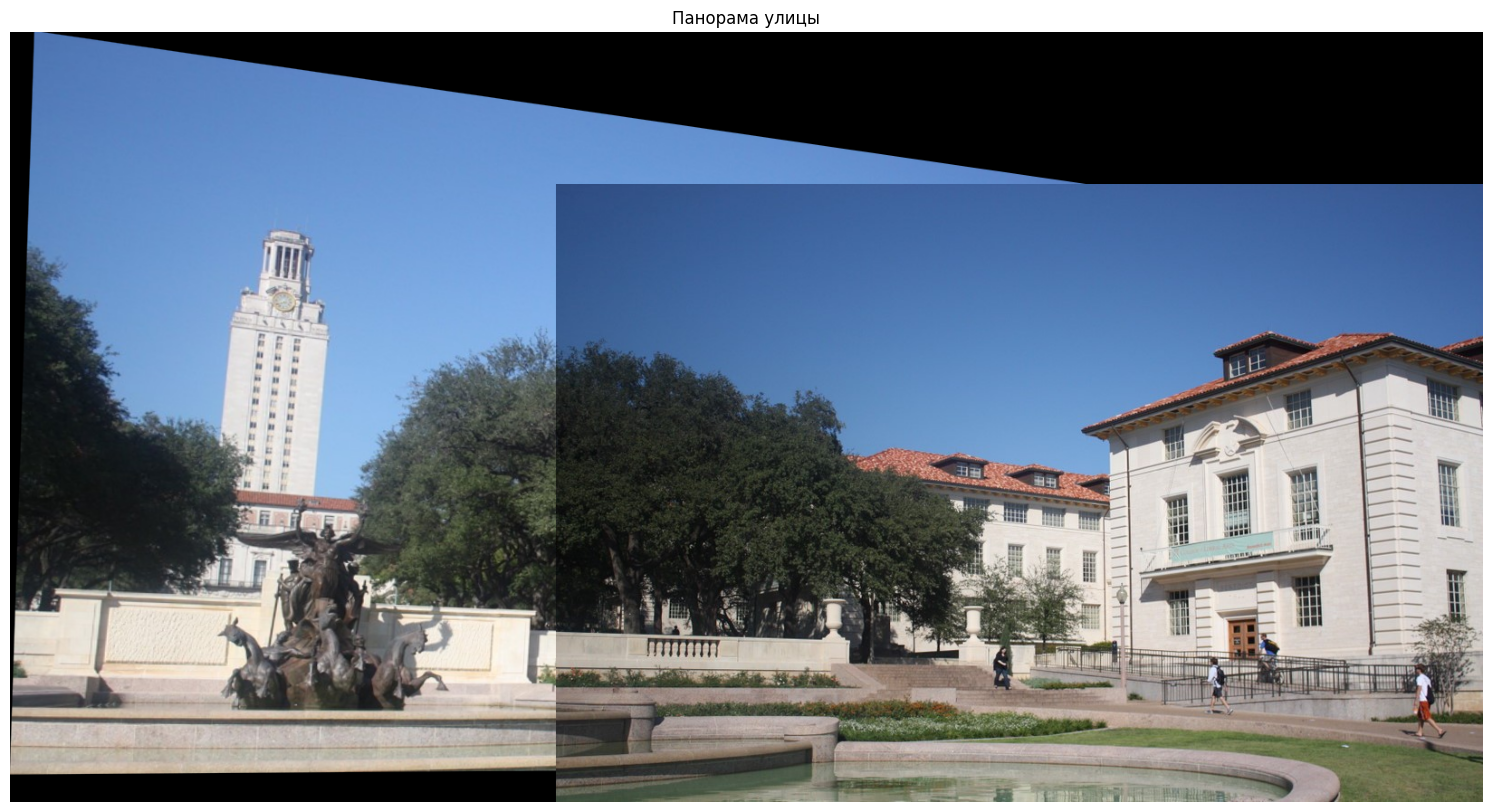

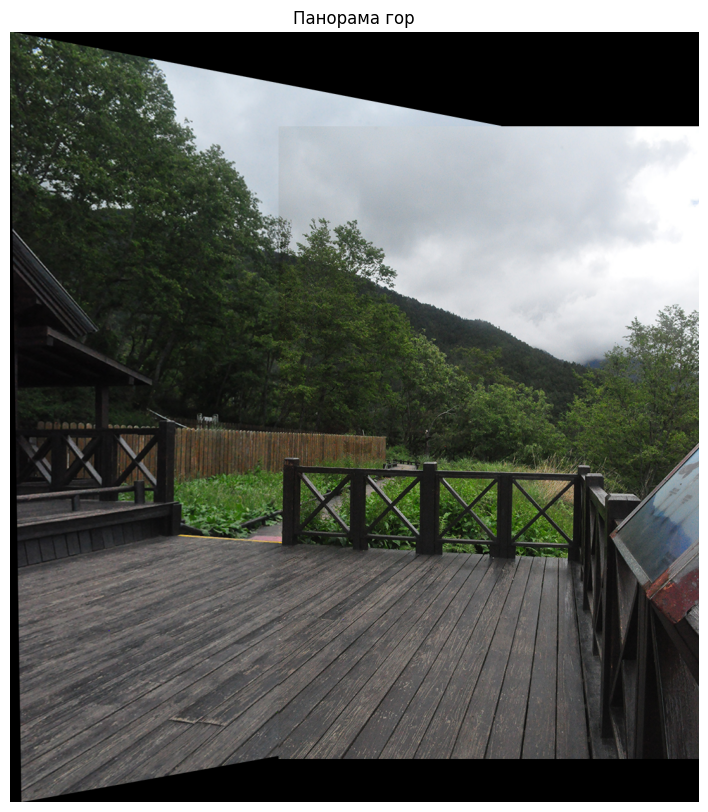

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(image1_path, image2_path):
    """Создает панораму из двух изображений по указанным путям."""

    # Загрузка изображений
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    if img1 is None or img2 is None:
        raise FileNotFoundError("Одно из изображений не найдено.")

    # Преобразование в градации серого
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Инициализация SIFT и обнаружение ключевых точек
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Использование FLANN для сопоставления дескрипторов
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Фильтрация совпадений
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 10:
        raise ValueError("Недостаточно совпадений для построения панорамы.")

    # Получение координат точек
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Построение матрицы гомографии
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Вычисление размеров результирующего изображения
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    points_img2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)
    points_img1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)

    # С помощью гомографии трансформируем углы второго изображения
    transformed_points = cv2.perspectiveTransform(points_img2, H)
    all_points = np.concatenate((points_img1, transformed_points), axis=0)

    [x_min, y_min] = np.int32(all_points.min(axis=0).flatten())
    [x_max, y_max] = np.int32(all_points.max(axis=0).flatten())

    translation_dist = [-x_min, -y_min]
    result_width = x_max - x_min
    result_height = y_max - y_min

    # Создаем трансляционную матрицу и корректируем матрицу гомографии
    translation_matrix = np.array([[1, 0, translation_dist[0]],
                                    [0, 1, translation_dist[1]],
                                    [0, 0, 1]])

    H = translation_matrix @ H

    # Преобразуем первое изображение и накладываем второе
    panorama = cv2.warpPerspective(img1, H, (result_width, result_height))

    panorama[translation_dist[1]:translation_dist[1] + height2,
             translation_dist[0]:translation_dist[0] + width2] = img2

    return panorama

# Примеры использования функции
panorama_street = stitch_images("street_1.jpeg", "street_2.jpeg")
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama_street, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Панорама улицы")
plt.show()

# Пример для пары изображений mountain_*.jpg
panorama_mountain = stitch_images("mountain_1.jpg", "mountain_2.jpg")
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama_mountain, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Панорама гор")
plt.show()


In [ ]:
# ваш код здесь и ниже

# Сравните результаты выполнения операций между классом Stitcher_create из OpenCV и кастомным методом через алгоритм SIFT. Что можно улучшить в выходном результате?

Можно улучшить склеиваемость результатов, на данный момент очень бросается в глаза место склейки, беглый поиск говорит о том, что, возможно стоит использовать другие методы обнаружения ключевых точек, также можно попробовать изменить параметры гомографии и дополнительное выравнивание изображений перед сшиванием

# Доп задание*, которое также будем проходить на практике: Как нужно обновить написанный выше код, чтобы можно было подавать на вход более 2-ух изображения для создания панорамы?